In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

In [63]:
# Read the CSV file
file_path = 'Life_Expectancy_Data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [65]:
# Create a function to classify population size into categories
def categorize_population(population):
    if 1000 <= population <= 29999:
        return 'Small'
    elif 30000 <= population <= 99999:
        return 'Medium'
    elif population >= 100000:
        return 'Large'
    else:
        return 'Unknown'  # For cases with missing or unexpected population values

# Apply the function to create the new column
data['Population Range'] = data['Population'].apply(categorize_population)

# Display the count of each category to check the distribution
population_range_counts = data['Population Range'].value_counts()
population_range_counts

Population Range
Large      1874
Unknown     683
Small       205
Medium      176
Name: count, dtype: int64

In [67]:
# Define a function to create a lifestyle category based on Alcohol consumption and BMI
def categorize_lifestyle(row):
    alcohol = row['Alcohol']
    bmi = row[' BMI ']  # Column has leading/trailing spaces based on the original dataset

    if pd.isna(alcohol) or pd.isna(bmi):
        return 'Unknown'
    elif alcohol < 2.5 and bmi < 18.5:
        return 'Low Risk - Lean/Low Alcohol'
    elif alcohol < 2.5 and bmi >= 18.5:
        return 'Moderate - Lean/Low Alcohol'
    elif alcohol >= 2.5 and bmi < 25:
        return 'Moderate - Fit/Moderate Alcohol'
    elif alcohol >= 2.5 and bmi >= 25:
        return 'High Risk - Overweight/High Alcohol'
    else:
        return 'Other'

# Apply the function to create the new feature
data['Lifestyle'] = data.apply(categorize_lifestyle, axis=1)

# Display the distribution of the new feature and the first few rows
lifestyle_distribution = data['Lifestyle'].value_counts()
updated_lifestyle_data = data[['Country', 'Year', 'Alcohol', ' BMI ', 'Lifestyle']].head()

lifestyle_distribution, updated_lifestyle_data

(Lifestyle
 High Risk - Overweight/High Alcohol    1210
 Moderate - Lean/Low Alcohol             746
 Moderate - Fit/Moderate Alcohol         397
 Low Risk - Lean/Low Alcohol             374
 Unknown                                 211
 Name: count, dtype: int64,
        Country  Year  Alcohol   BMI                     Lifestyle
 0  Afghanistan  2015     0.01   19.1  Moderate - Lean/Low Alcohol
 1  Afghanistan  2014     0.01   18.6  Moderate - Lean/Low Alcohol
 2  Afghanistan  2013     0.01   18.1  Low Risk - Lean/Low Alcohol
 3  Afghanistan  2012     0.01   17.6  Low Risk - Lean/Low Alcohol
 4  Afghanistan  2011     0.01   17.2  Low Risk - Lean/Low Alcohol)

In [69]:
# Define a function to create an economy category based on Population and GDP
def categorize_economy(row):
    population = row['Population']
    gdp = row['GDP']

    if pd.isna(population) or pd.isna(gdp):
        return 'Unknown'
    elif population < 100000 and gdp < 10000:
        return 'Small Economy - Low GDP'
    elif population >= 100000 and gdp < 10000:
        return 'Large Population - Low GDP'
    elif population >= 100000 and gdp >= 10000:
        return 'Strong Economy - High GDP'
    elif population < 100000 and gdp >= 10000:
        return 'Small but High GDP'
    else:
        return 'Other'

# Apply the function to create the new feature
data['Economy'] = data.apply(categorize_economy, axis=1)

# Display the distribution of the new feature and the first few rows
economy_distribution = data['Economy'].value_counts()
updated_economy_data = data[['Country', 'Year', 'Population', 'GDP', 'Economy']].head()

economy_distribution, updated_economy_data

(Economy
 Large Population - Low GDP    1584
 Unknown                        674
 Small Economy - Low GDP        341
 Strong Economy - High GDP      273
 Small but High GDP              66
 Name: count, dtype: int64,
        Country  Year  Population         GDP                     Economy
 0  Afghanistan  2015  33736494.0  584.259210  Large Population - Low GDP
 1  Afghanistan  2014    327582.0  612.696514  Large Population - Low GDP
 2  Afghanistan  2013  31731688.0  631.744976  Large Population - Low GDP
 3  Afghanistan  2012   3696958.0  669.959000  Large Population - Low GDP
 4  Afghanistan  2011   2978599.0   63.537231  Large Population - Low GDP)

In [71]:
# Calculate the death ratio as the ratio between Adult Mortality and infant deaths
# To avoid division by zero, handle cases where infant deaths are 0
def calculate_death_ratio(row):
    if row['infant deaths'] == 0 or pd.isna(row['Adult Mortality']):
        return 'Undefined'
    return row['Adult Mortality'] / row['infant deaths']

# Apply the function to calculate the death ratio
data['Death Ratio'] = data.apply(calculate_death_ratio, axis=1)

# Display basic statistics and the first few rows of the new feature
death_ratio_stats = data['Death Ratio'].value_counts()
updated_death_ratio_data = data[['Country', 'Year', 'Adult Mortality', 'infant deaths', 'Death Ratio']].head()

death_ratio_stats.head(), updated_death_ratio_data

(Death Ratio
 Undefined    848
 4.0           13
 11.0          11
 12.0           9
 66.0           9
 Name: count, dtype: int64,
        Country  Year  Adult Mortality  infant deaths Death Ratio
 0  Afghanistan  2015            263.0             62    4.241935
 1  Afghanistan  2014            271.0             64    4.234375
 2  Afghanistan  2013            268.0             66    4.060606
 3  Afghanistan  2012            272.0             69    3.942029
 4  Afghanistan  2011            275.0             71    3.873239)

In [73]:
# Displaying the feature-engineered results for review
feature_engineered_results = data[['Country', 'Year', 'Adult Mortality', 'infant deaths', 'Death Ratio']].head()
feature_engineered_results

,Country,Year,Adult Mortality,infant deaths,Death Ratio
0,Afghanistan,2015,263.0,62,4.241935
1,Afghanistan,2014,271.0,64,4.234375
2,Afghanistan,2013,268.0,66,4.060606
3,Afghanistan,2012,272.0,69,3.942029
4,Afghanistan,2011,275.0,71,3.873239


In [75]:
# Display the descriptive statistics for the 'Death Ratio' feature to provide insights across the entire dataset
death_ratio_stats = data['Death Ratio'].describe()

# Return the computed statistics to the user
death_ratio_stats

count          2938
unique         1425
top       Undefined
freq            848
Name: Death Ratio, dtype: object

In [77]:
# Check for missing values in the dataset
missing_values_summary = data.isnull().sum()

# Display columns with missing values and their counts
missing_values_summary[missing_values_summary > 0]

Life expectancy                     10
Adult Mortality                     10
Alcohol                            194
Hepatitis B                        553
 BMI                                34
Polio                               19
Total expenditure                  226
Diphtheria                          19
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

In [79]:
# Impute missing values using explicit assignments
data['Life expectancy '] = data['Life expectancy '].fillna(data['Life expectancy '].mean())
data['Adult Mortality'] = data['Adult Mortality'].fillna(data['Adult Mortality'].median())
data['Alcohol'] = data['Alcohol'].fillna(data['Alcohol'].median())
data['Hepatitis B'] = data['Hepatitis B'].ffill()
data[' BMI '] = data[' BMI '].fillna(data[' BMI '].mean())
data['Polio'] = data['Polio'].ffill()
data['Total expenditure'] = data['Total expenditure'].fillna(data['Total expenditure'].median())
data['Diphtheria '] = data['Diphtheria '].ffill()
data['GDP'] = data['GDP'].fillna(data['GDP'].median())
data['Population'] = data['Population'].fillna(data['Population'].median())
data[' thinness  1-19 years'] = data[' thinness  1-19 years'].fillna(data[' thinness  1-19 years'].mean())
data[' thinness 5-9 years'] = data[' thinness 5-9 years'].fillna(data[' thinness 5-9 years'].mean())
data['Income composition of resources'] = data['Income composition of resources'].fillna(
    data['Income composition of resources'].median())
data['Schooling'] = data['Schooling'].ffill()

# Drop any remaining observations with missing values
cleaned_data = data.dropna()

# Verify if any missing values remain
remaining_missing_values = cleaned_data.isnull().sum().sum()
remaining_missing_values

0

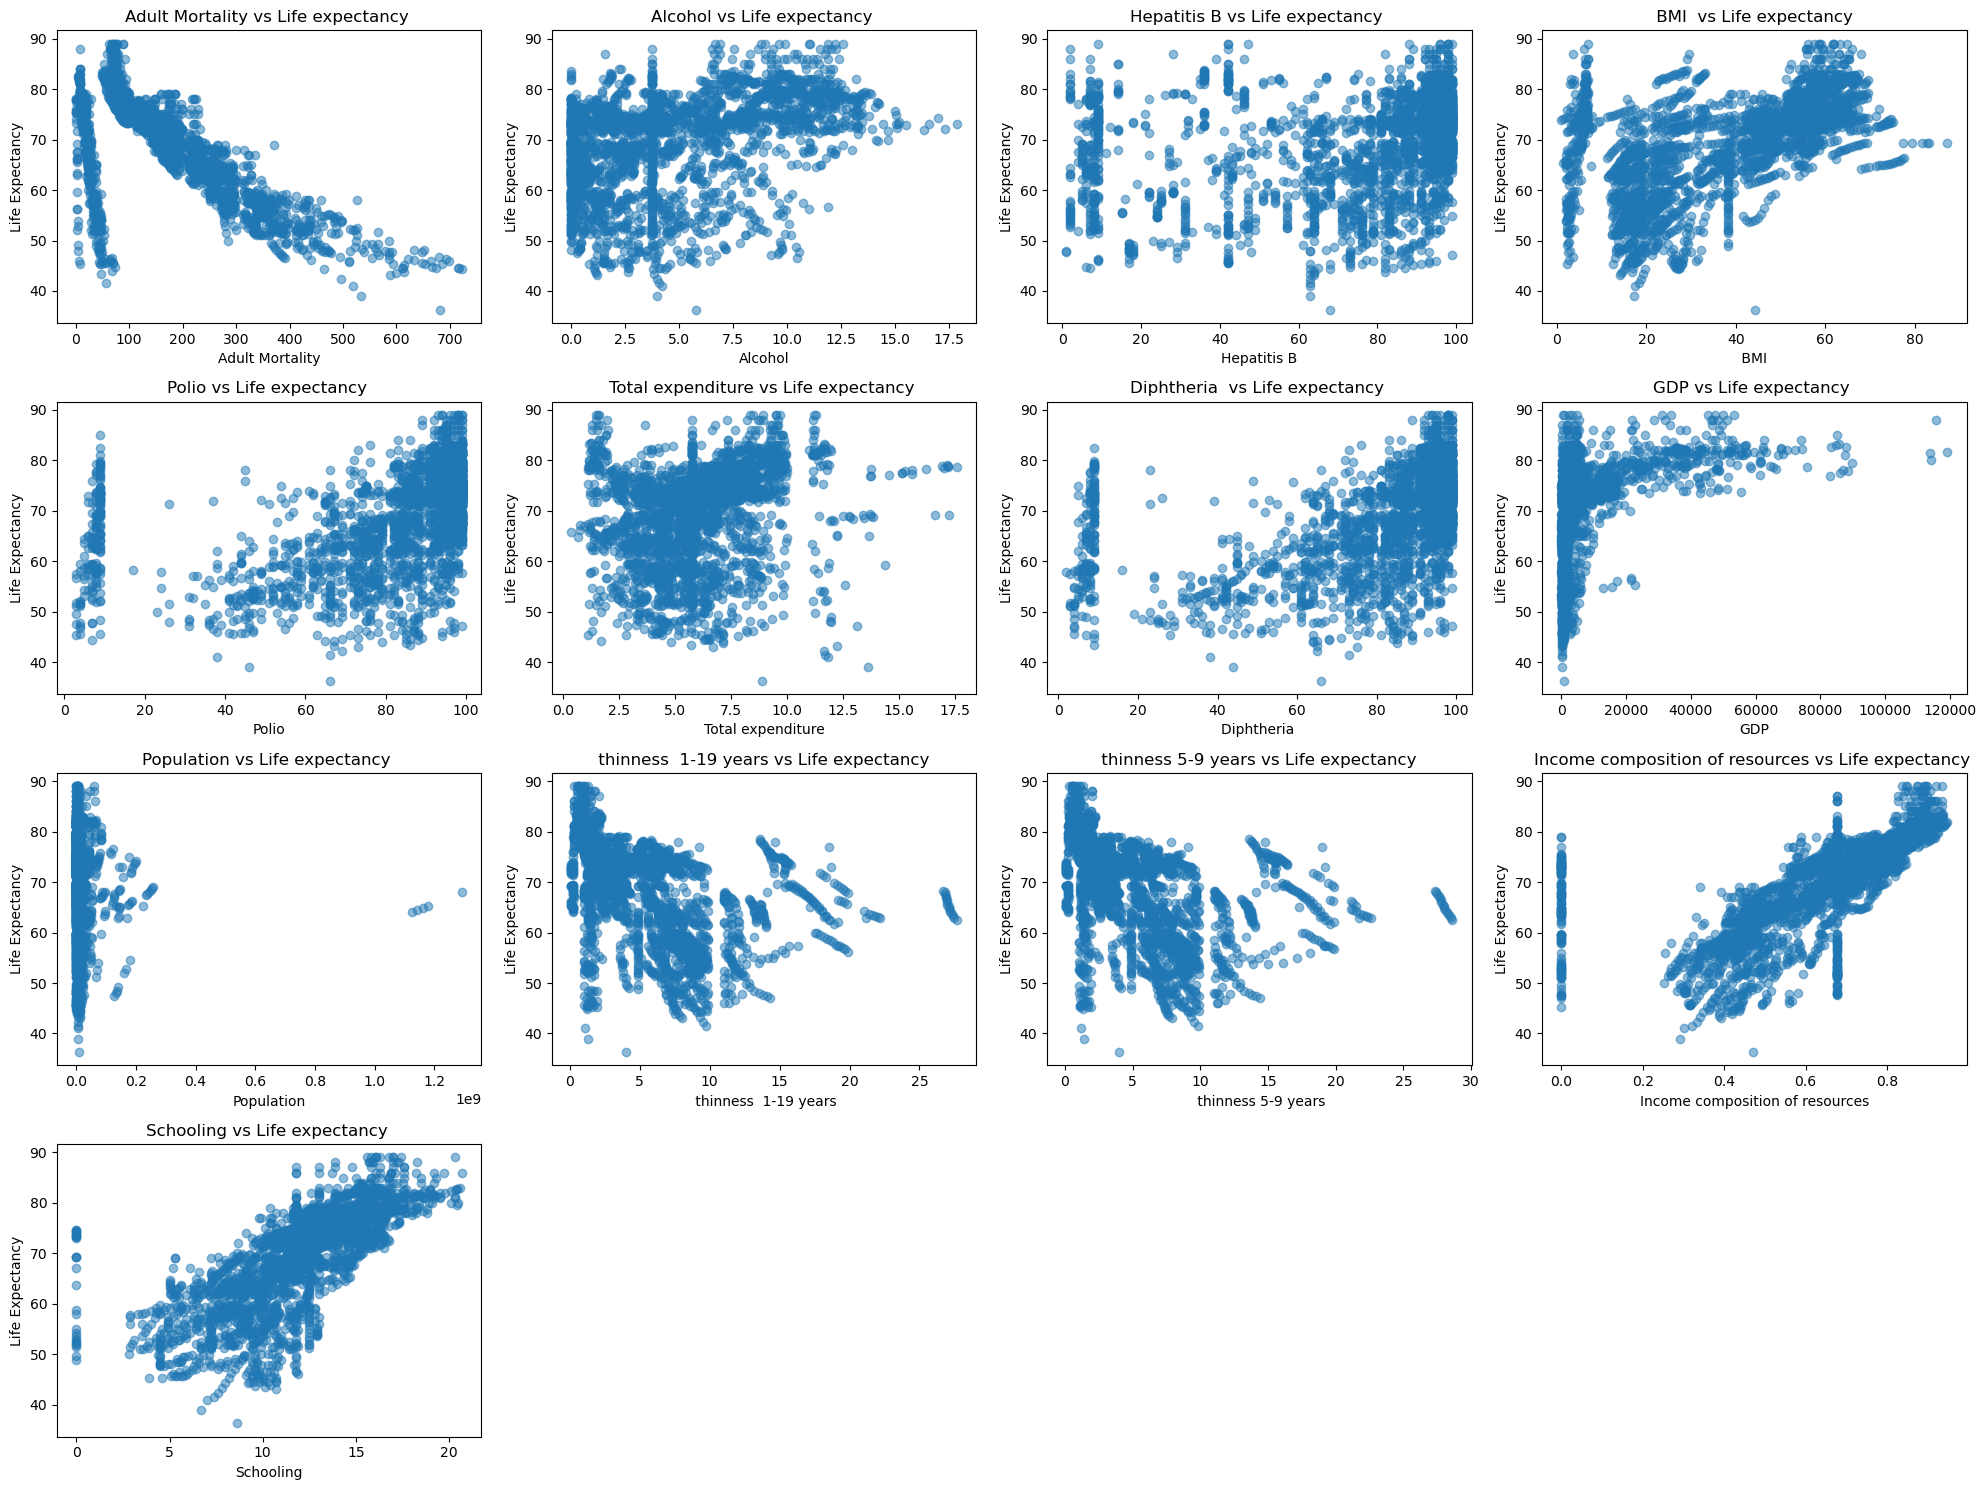

In [81]:
# Identify the target variable and potential predictors
target_variable = 'Life expectancy '
predictors = ['Adult Mortality', 'Alcohol', 'Hepatitis B', ' BMI ', 'Polio',
              'Total expenditure', 'Diphtheria ', 'GDP', 'Population',
              ' thinness  1-19 years', ' thinness 5-9 years',
              'Income composition of resources', 'Schooling']

# Set up scatter plots to check relationships and linearity
plt.figure(figsize=(20, 15))
for i, predictor in enumerate(predictors, 1):
    plt.subplot(4, 4, i)
    plt.scatter(cleaned_data[predictor], cleaned_data[target_variable], alpha=0.5)
    plt.title(f'{predictor} vs {target_variable}')
    plt.xlabel(predictor)
    plt.ylabel('Life Expectancy')

plt.tight_layout()
plt.show()

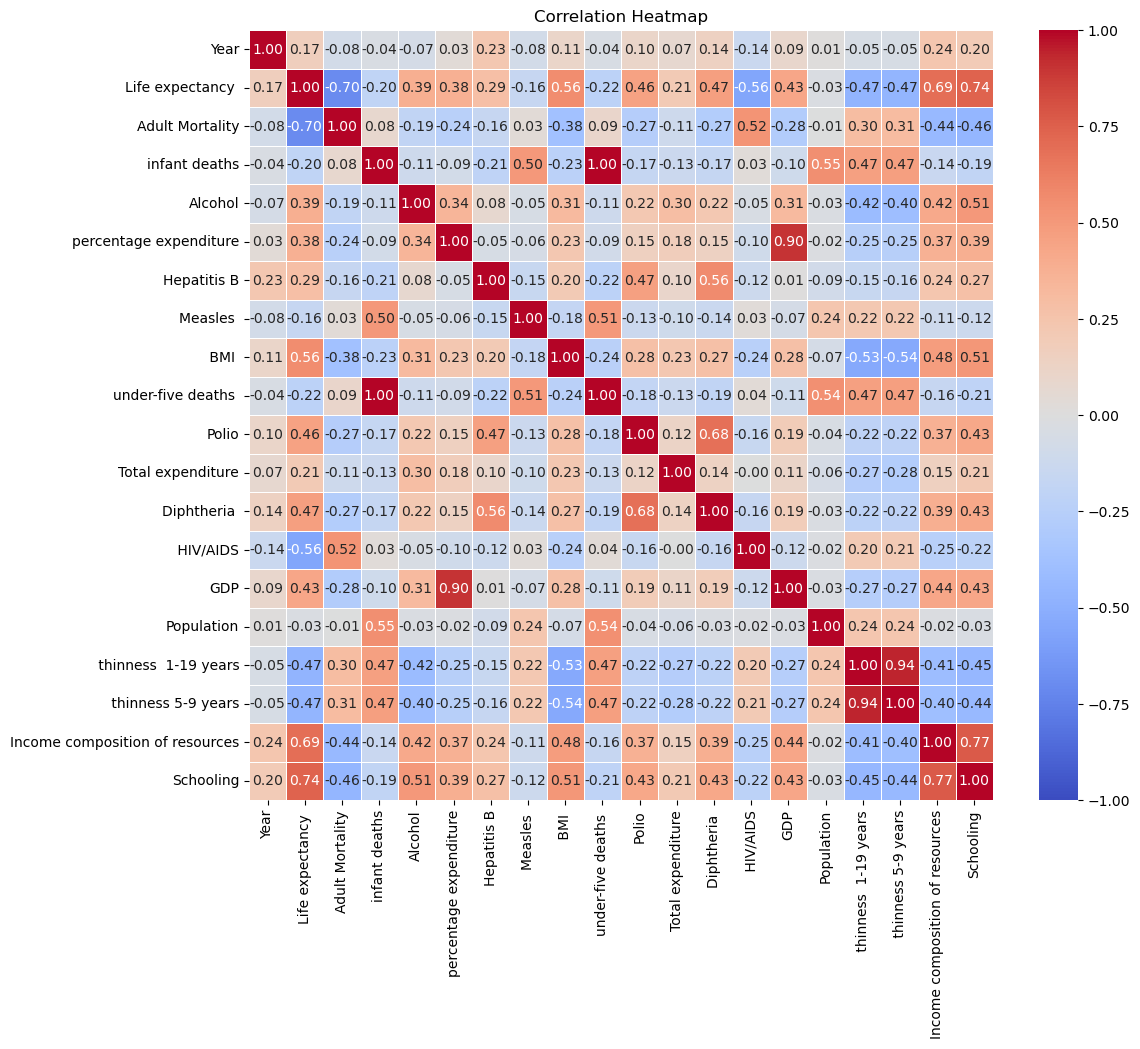

[('infant deaths', 'under-five deaths ', 0.996628882039801),
 ('percentage expenditure', 'GDP', 0.9018191027160023),
 ('under-five deaths ', 'infant deaths', 0.996628882039801),
 ('GDP', 'percentage expenditure', 0.9018191027160023),
 (' thinness  1-19 years', ' thinness 5-9 years', 0.9391019921914646),
 (' thinness 5-9 years', ' thinness  1-19 years', 0.9391019921914646),
 ('Income composition of resources', 'Schooling', 0.7724591461274853),
 ('Schooling', 'Income composition of resources', 0.7724591461274853)]

In [82]:
# Exclude non-numeric columns from the correlation calculation
numeric_columns = cleaned_data.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Identify pairs of features with a correlation higher than 0.75 (multicollinearity threshold)
high_correlation_pairs = np.where((np.abs(correlation_matrix) > 0.75) & (correlation_matrix != 1))
correlated_features = [(correlation_matrix.index[x], correlation_matrix.columns[y], correlation_matrix.values[x, y])
                       for x, y in zip(*high_correlation_pairs)]

correlated_features

In [83]:
# Dropping variables with correlations above 0.75 to address multicollinearity
columns_to_drop = ['under-five deaths ', 'percentage expenditure', ' thinness 5-9 years']
cleaned_data = cleaned_data.drop(columns=columns_to_drop)

# Verify the resulting columns
remaining_columns = cleaned_data.columns
remaining_columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'Hepatitis B', 'Measles ', ' BMI ', 'Polio',
       'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', 'Income composition of resources', 'Schooling',
       'Population Range', 'Lifestyle', 'Economy', 'Death Ratio'],
      dtype='object')

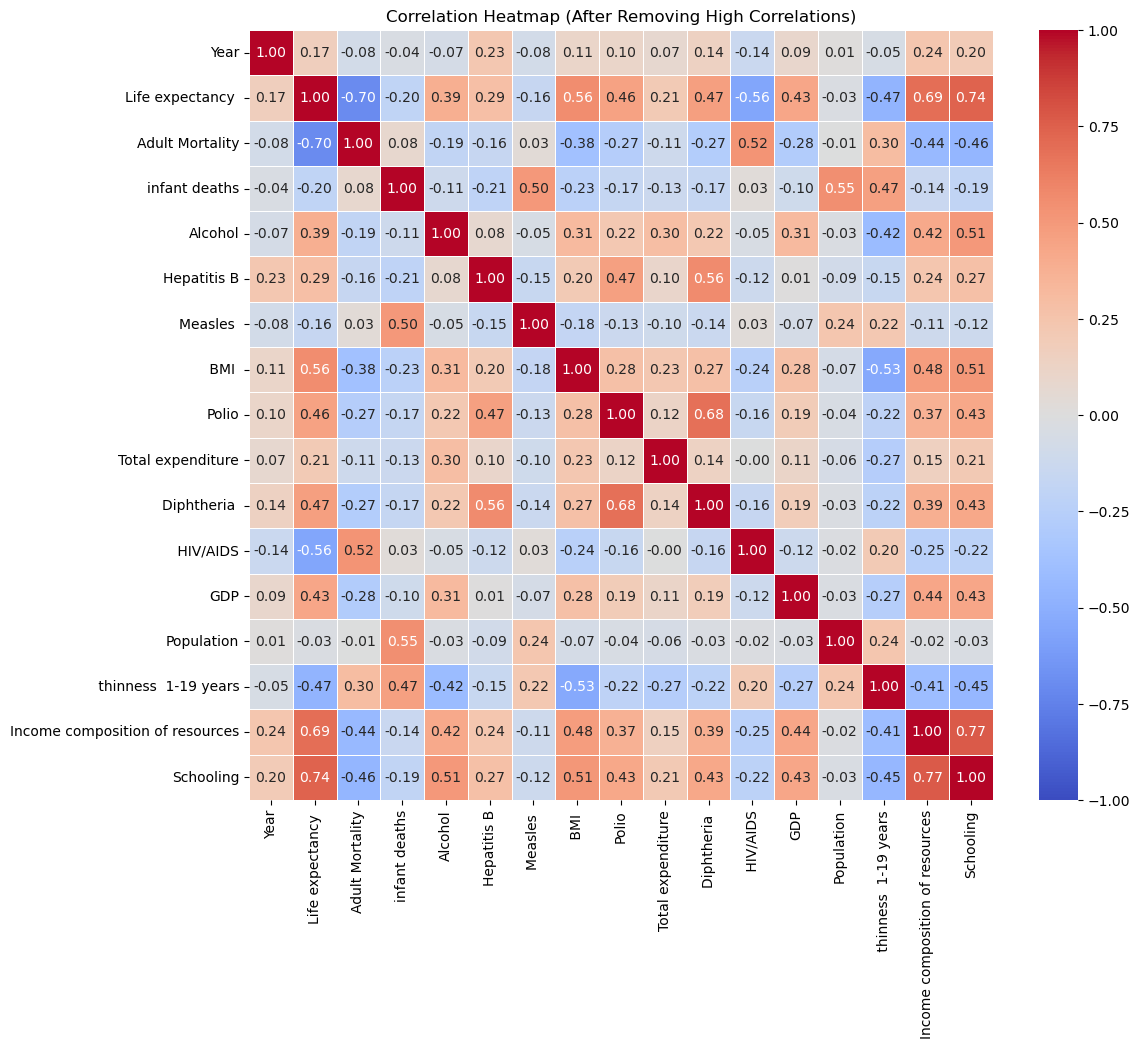

In [84]:
# Recalculate the correlation matrix with the reduced dataset
numeric_columns_reduced = cleaned_data.select_dtypes(include=[np.number])
correlation_matrix_reduced = numeric_columns_reduced.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate the heatmap
sns.heatmap(correlation_matrix_reduced, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap (After Removing High Correlations)')
plt.show()

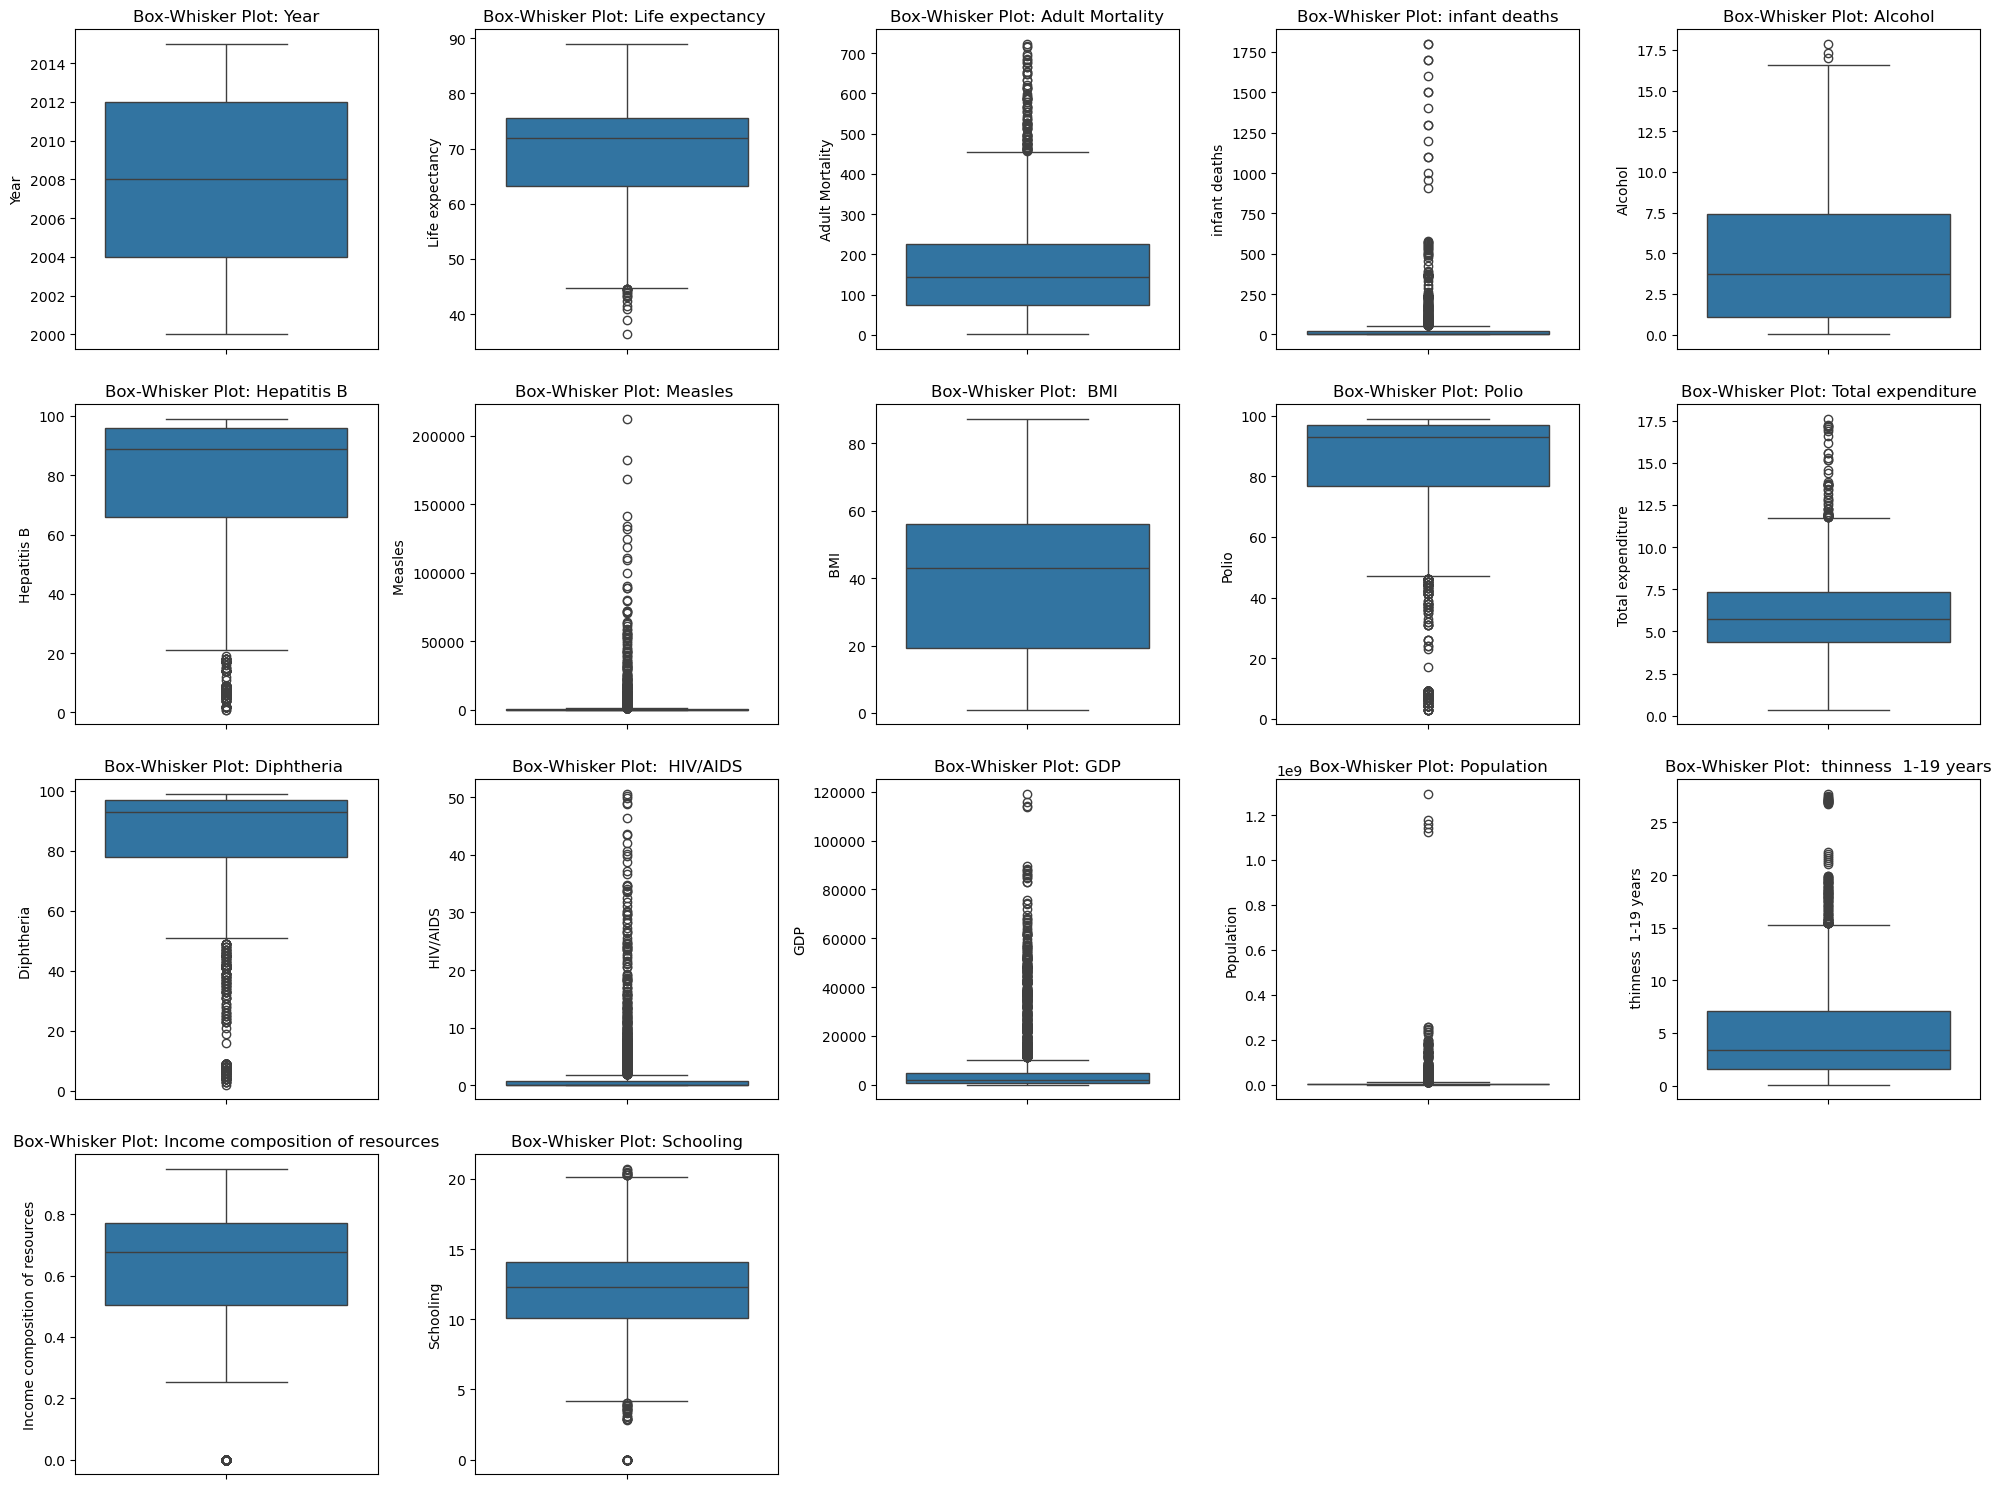

In [86]:
# Generate box-whisker plots for all numeric columns to identify possible outliers
plt.figure(figsize=(20, 15))

# Loop through each numeric column and plot
for i, column in enumerate(numeric_columns_reduced.columns, 1):
    plt.subplot(4, 5, i)
    sns.boxplot(y=cleaned_data[column])
    plt.title(f'Box-Whisker Plot: {column}')

plt.tight_layout()
plt.show()

In [89]:
# Extract relevant variables for analysis
healthcare_expenditure_life_expectancy = cleaned_data[['Life expectancy ', 'Total expenditure']]
schooling_life_expectancy = cleaned_data[['Life expectancy ', 'Schooling']]
alcohol_life_expectancy = cleaned_data[['Life expectancy ', 'Alcohol']]
population_life_expectancy = cleaned_data[['Life expectancy ', 'Population']]

# Calculate correlation coefficients for better understanding
healthcare_corr = healthcare_expenditure_life_expectancy.corr().loc['Life expectancy ', 'Total expenditure']
schooling_corr = schooling_life_expectancy.corr().loc['Life expectancy ', 'Schooling']
alcohol_corr = alcohol_life_expectancy.corr().loc['Life expectancy ', 'Alcohol']
population_corr = population_life_expectancy.corr().loc['Life expectancy ', 'Population']

# Perform grouping and descriptive statistics to summarize trends
below_65_life_exp = cleaned_data[cleaned_data['Life expectancy '] < 65]
avg_expenditure_below_65 = below_65_life_exp['Total expenditure'].mean()
avg_expenditure_above_65 = cleaned_data[cleaned_data['Life expectancy '] >= 65]['Total expenditure'].mean()

# Return the key insights
healthcare_corr, avg_expenditure_below_65, avg_expenditure_above_65, schooling_corr, alcohol_corr, population_corr

(0.20793989396219095,
 5.382126909518214,
 6.1450934355534255,
 0.7374392190105906,
 0.3898466637350483,
 -0.02884453402385741)

In [90]:
# Drop previously identified highly correlated variables
columns_to_drop = ['under-five deaths ', 'percentage expenditure', ' thinness 5-9 years']
data = data.drop(columns=columns_to_drop)

# Handle missing values
data['Population'] = data['Population'].fillna(data['Population'].median())
cleaned_data = data.dropna()

# Define features and target variable
X = cleaned_data.drop(['Life expectancy '], axis=1).select_dtypes(include=[np.number])  # Select numeric features only
y = cleaned_data['Life expectancy ']

# Split the data into training and testing sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Check the sizes of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2203, 16), (735, 16), (2203,), (735,))

In [92]:
# Train the linear regression model
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)

# Predictions on training, test, and entire datasets
y_train_pred = linear_regression_model.predict(X_train)
y_test_pred = linear_regression_model.predict(X_test)
y_all_pred = linear_regression_model.predict(X)

# Calculate performance metrics (MSE and R2 score) for each dataset
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

all_mse = mean_squared_error(y, y_all_pred)
all_r2 = r2_score(y, y_all_pred)

train_mse, train_r2, test_mse, test_r2, all_mse, all_r2

(16.831642851019716,
 0.8138457188608345,
 17.48353938069013,
 0.8058079181895821,
 16.994727925664968,
 0.8119312677843368)

In [93]:
# Calculate MSE, RMSE, R2, and MAPE
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
all_mse = mean_squared_error(y, y_all_pred)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
all_rmse = np.sqrt(all_mse)

train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
all_mape = mean_absolute_percentage_error(y, y_all_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
all_r2 = r2_score(y, y_all_pred)

(train_rmse, test_rmse, all_rmse, train_mape, test_mape, all_mape, train_r2, test_r2, all_r2)

(4.102638523075085,
 4.181332249497776,
 4.122466243120126,
 0.04690310698884331,
 0.046610579900858845,
 0.0468299254334762,
 0.8138457188608345,
 0.8058079181895821,
 0.8119312677843368)

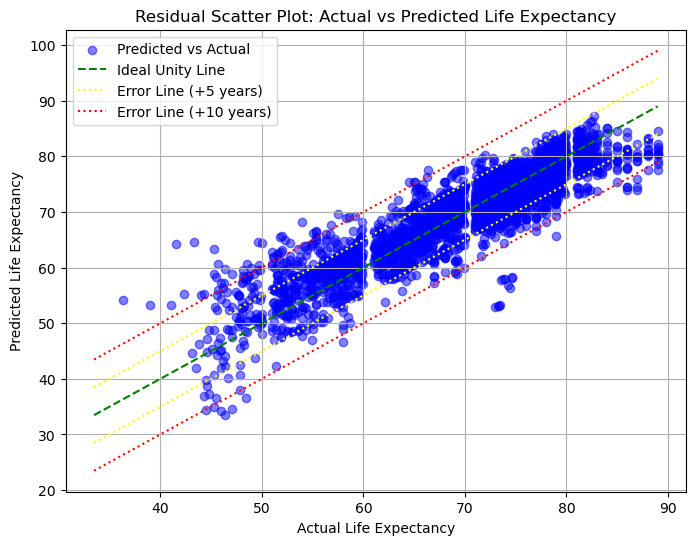

In [94]:
# Create the scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y, y_all_pred, alpha=0.5, label='Predicted vs Actual', color='blue')

# Plot the ideal unity line
min_val, max_val = min(y.min(), y_all_pred.min()), max(y.max(), y_all_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='green', linestyle='--', label='Ideal Unity Line')

# Plot the dotted error lines for +/- 5 years (yellow) and +/- 10 years (red)
plt.plot([min_val, max_val], [min_val + 5, max_val + 5], color='yellow', linestyle=':', label='Error Line (+5 years)')
plt.plot([min_val, max_val], [min_val - 5, max_val - 5], color='yellow', linestyle=':')
plt.plot([min_val, max_val], [min_val + 10, max_val + 10], color='red', linestyle=':', label='Error Line (+10 years)')
plt.plot([min_val, max_val], [min_val - 10, max_val - 10], color='red', linestyle=':')

# Labels and legend
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.title('Residual Scatter Plot: Actual vs Predicted Life Expectancy')
plt.legend()
plt.grid(True)
plt.show()

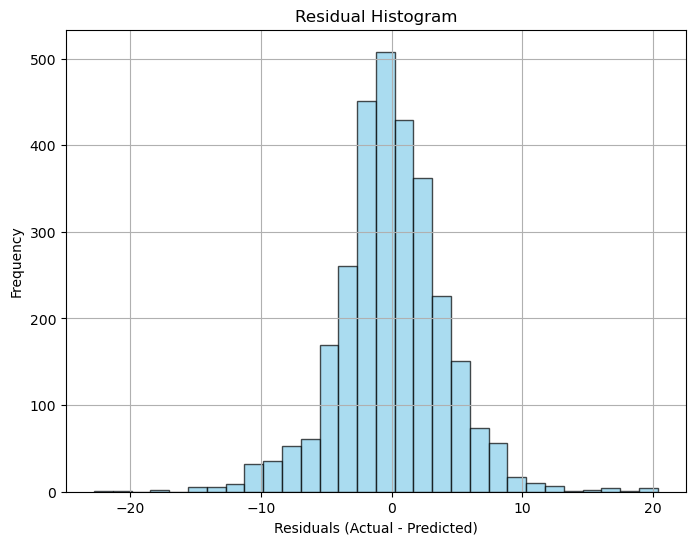

In [101]:
# Split and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model = LinearRegression().fit(X_train, y_train)

# Calculate residuals
residuals = y - model.predict(X)

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7, color='skyblue')
plt.title('Residual Histogram')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [103]:
# Perform 5-fold cross-validation using R2 as the scoring metric
cv_scores = cross_val_score(linear_regression_model, X, y, cv=5, scoring='r2')

# Calculate the mean and standard deviation of the cross-validation scores
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

mean_cv_score, std_cv_score

(0.783273471541477, 0.03074350446568269)

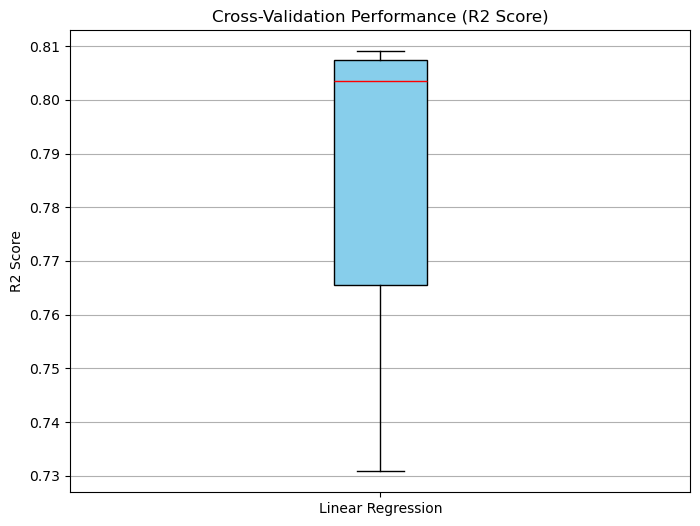

In [105]:
# Generate the box plot
plt.figure(figsize=(8, 6))
plt.boxplot(cv_scores, vert=True, patch_artist=True, 
            boxprops=dict(facecolor='skyblue', color='black'), 
            medianprops=dict(color='red'), 
            whiskerprops=dict(color='black'), 
            capprops=dict(color='black'), 
            flierprops=dict(color='red', marker='o'))

plt.title('Cross-Validation Performance (R2 Score)')
plt.ylabel('R2 Score')
plt.xticks([1], ['Linear Regression'])
plt.grid(True, axis='y')
plt.show()

In [107]:
# Calculate mean and standard deviation of performance
mean_cv_performance = np.mean(cv_scores)
std_cv_performance = np.std(cv_scores)

mean_cv_performance, std_cv_performance

(0.783273471541477, 0.03074350446568269)

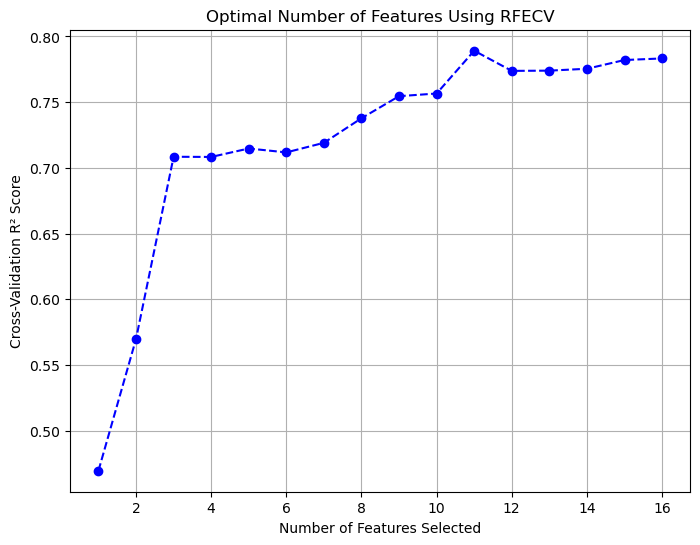

(11,
 ['Year',
  'Adult Mortality',
  'Alcohol',
  ' BMI ',
  'Polio',
  'Total expenditure',
  'Diphtheria ',
  ' HIV/AIDS',
  ' thinness  1-19 years',
  'Income composition of resources',
  'Schooling'])

In [109]:
# Initialize the model and perform recursive feature elimination with cross-validation (RFECV)
linear_regression_model = LinearRegression()
rfecv = RFECV(estimator=linear_regression_model, step=1, cv=5, scoring='r2')

# Fit the RFECV model
rfecv.fit(X, y)

# Optimal number of features
optimal_features_count = rfecv.n_features_

# Selected features
selected_features = X.columns[rfecv.support_]

# Plotting the number of features vs. cross-validation scores
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], 
         marker='o', linestyle='--', color='blue')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross-Validation R² Score')
plt.title('Optimal Number of Features Using RFECV')
plt.grid(True)
plt.show()

optimal_features_count, selected_features.tolist()